# 15 Minute Series: Spatial Analysis of San Diego
---

*Cara Higashi, Robert Lopez, Joseph Sy, Giovanni Ramos Gutierrez*

## Data Import
---

In [1]:
from geosnap import DataStore
import warnings
warnings.filterwarnings('ignore')
datasets = DataStore("/srv/data/geonsap")

/opt/tljh/user/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/tljh/user/lib/python3.10/site-packages/quantecon/lss.py:20: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def simulate_linear_model(A, x0, v, ts_length):


In [2]:
import os
import pandana as pdna

network_path = './networks/41740.h5'

if not os.path.exists(network_path):
    import quilt3 as q3
    b = q3.Bucket("s3://spatial-ucr")
    b.fetch("osm/metro_networks_8k/41740.h5", network_path)
sd_network = pdna.Network.from_hdf5(network_path)

Generating contraction hierarchies with 32 threads.
Setting CH node vector of size 332554
Setting CH edge vector of size 522484
Range graph removed 143094 edges of 1044968
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [3]:
schools = datasets.nces(dataset="schools")


In [4]:
ca_schools = schools[schools["STFIP15"] == "06"]


The script filters the schools dataset to include only those entries where the "STFIP15" column equals "06", which might represent schools in California.

In [5]:
#ca_schools

### Importing City of San Diego Boundary

In [6]:
import geopandas as gpd
file_path = 'data/sd_boundary/san_diego_boundary_datasd.shp'
san_diego_boundary = gpd.read_file(file_path)
#san_diego_boundary.explore()

In [7]:
san_diego_boundary.crs

<Projected CRS: EPSG:2230>
Name: NAD83 / California zone 6 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Imperial; Orange; Riverside; San Diego.
- bounds: (-118.15, 32.53, -114.42, 34.08)
Coordinate Operation:
- name: SPCS83 California zone 6 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
ca_schools = ca_schools.to_crs('EPSG:2230')

Reprojected the ca_schools dataset to match the CRS of the san_diego_boundary using the same EPSG:2230. This step is essential to ensure that all spatial operations such as intersections or distance calculations between the school locations and the San Diego boundary are accurate and meaningful.

In [9]:
Sd_schools = gpd.sjoin(ca_schools, san_diego_boundary, how='inner', op='within')

In [10]:
sd_schools = Sd_schools.to_crs(epsg=4269)
#sd_schools.explore()

The operation is intended to select only those schools that are within the San Diego boundary, using an inner join. This means the resulting GeoDataFrame, Sd_schools, will only include schools that are located within San Diego.

### Creating Isochrones for Schools in San Diego

In [11]:
from geosnap.analyze import isochrones_from_id, isochrones_from_gdf, pdna_to_adj 

```isochrones = isochrones_from_gdf(sd_schools, threshold=1600, network=sd_network)```

```s20 = isochrones.dissolve()```

```s20.to_file("data/sd_schools_iso/s20.shp")```

In [12]:
file_path ='data/sd_schools_iso/s20.shp'
s20 = gpd.read_file(file_path)

Generated isochrones based on the sd_schools GeoDataFrame with a specified threshold of 1600 meters, using the San Diego road network (sd_network). This creates areas that can be reached within a specific time or distance from the schools, illustrating the 1600-meter accessibility area around each school.

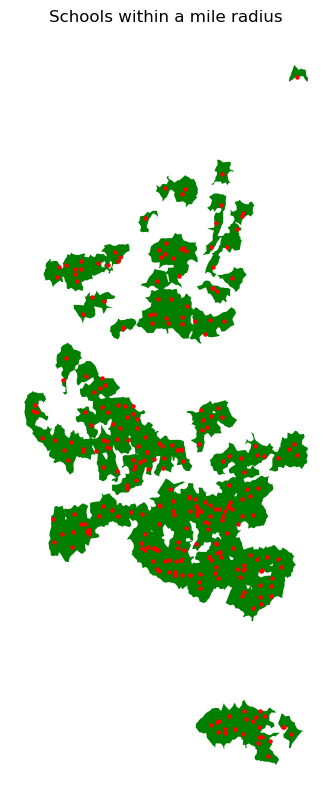

In [13]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(12, 10))

s20.plot(color='green', ax=ax)

sd_schools.plot(ax=ax, color='red', markersize=5)

plt.title('Schools within a mile radius')

ax.axis('off')

plt.show()

### Hospitals

One dataset, referred to as hospitals, contained information specifically about hospitals, while the other dataset, named health, included various types of healthcare facilities.

In [14]:
import geopandas as gpd
import pandas as pd
file_path = 'data/hospitals/Hospitals.shp'

hospitals = gpd.read_file(file_path)

In [15]:
file_path = 'data/health_sd/OSHPD_Healthcare_Facilities.shp'

health = gpd.read_file(file_path)

In [16]:
health = health.to_crs('EPSG:2230')

In [17]:
health = gpd.sjoin(health, san_diego_boundary, how='inner', op='within')

Performed a spatial join between the health GeoDataFrame and san_diego_boundary to filter the data, keeping only those facilities located within the San Diego boundary. This was done using an inner join with the operation set to 'within', ensuring that only facilities fully within the boundaries are included.

In [18]:
health=health.to_crs(epsg=4269)

In [19]:
hospitals = hospitals.to_crs('EPSG:2230')

In [20]:
hospitals = gpd.sjoin(hospitals, san_diego_boundary, how='inner', op='within')

Performed another spatial join between the hospitals GeoDataFrame and the san_diego_boundary under the same conditions as the ones mentioned for the dataset health.

In [21]:
#hospitals.explore()

In [22]:
hospitals = hospitals.to_crs(epsg=4269)


In [23]:
#hospitals.explore()

### Creating Isochrones for HealthCare Facilities

```isochrones2 = isochrones_from_gdf(hospitals, threshold=1600, network=sd_network)```

Generated isochrones around each hospital, defining these isochrones with a 1600-meter threshold using the San Diego road network (sd_network).

```s21=isochrones2.dissolve()```

```iso = isochrones_from_gdf(health, threshold=1600, network=sd_network)```

Generated isochrones for the health GeoDataFrame, which includes other types of healthcare facilities, again using a 1600-meter threshold and the same network.

In [24]:
#health_iso=gpd.overlay(s21,iso, how='union')

```health_iso=health_iso.dissolve()```

Used the geopandas.overlay() function to perform a union of the dissolved hospital isochrones and the isochrones from the other healthcare facilities. This operation combines the geographic areas covered by both sets of isochrones, effectively showing the total accessible area from any healthcare facility in the region.

```health_iso.to_file("data/sd_health_iso/health_iso.shp")```

In [25]:
file_path = 'data/sd_health_iso/health_iso.shp'
health_iso = gpd.read_file(file_path)

In [26]:
intersection_result1 = gpd.overlay(health_iso, s20, how='intersection')

Used the gpd.overlay() function from GeoPandas to find the intersection between the healthcare facility isochrones (health_iso) and the school isochrones (s20). This function computes the geometric intersection of the two sets of isochrones, which results in a new GeoDataFrame (intersection_result1).The intersection identifies areas where the isochrones of both healthcare facilities and schools overlap. This means these areas are accessible within a 15-minute travel time from both types of facilities

In [27]:
#intersection_result1.explore()

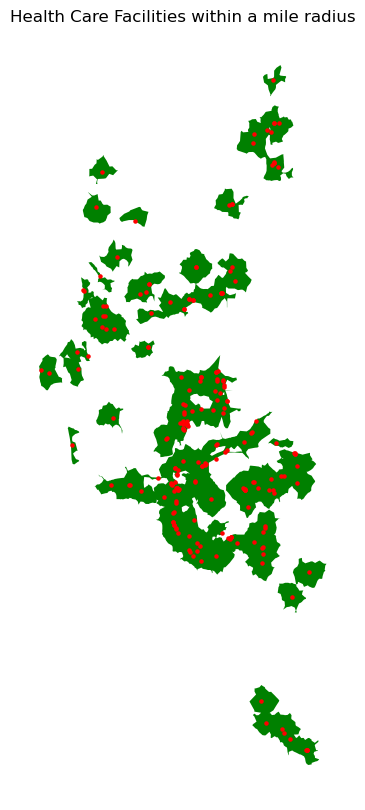

In [28]:
f, ax = plt.subplots(figsize=(12, 10))

health_iso.plot(color='green', ax=ax)

health.plot(ax=ax, color='red', markersize=5)

hospitals.plot(ax=ax, color='red', markersize=5)

plt.title('Health Care Facilities within a mile radius')

ax.axis('off')

plt.show()

### Parks

In [29]:
file_path = 'data/sd_parks'
parks = gpd.read_file(file_path)

In [30]:
#parks.explore()

In [31]:
parks_within_sd = parks[parks.geometry.within(san_diego_boundary.unary_union)]

Created a subset of the data (parks_within_sd) by filtering out parks that are entirely within the unified boundary of San Diego. This was achieved using the .within() method, applied to the unary_union of the San Diego boundary. The unary_union merges all boundaries into a single, continuous boundary shape

In [32]:
#parks_within_sd.explore()

In [33]:
parks_within_sd = parks_within_sd.to_crs(epsg=4269)

In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

def sample_boundary_points(polygon, num_points=3):
    
    return [polygon.boundary.interpolate(i / num_points, normalized=True) for i in range(num_points)]

boundary_points = [pt for polygon in parks_within_sd.geometry for pt in sample_boundary_points(polygon)]

boundary_gdf = gpd.GeoDataFrame(geometry=boundary_points, crs=parks_within_sd.crs)

Defined a function sample_boundary_points() that uses Shapely’s interpolate() method. This function is designed to return specific points along the boundary of a polygon, effectively sampling the boundary at regular intervals. I then applied this function to each park's geometry to generate points. These points represent sampled locations along the park boundaries, allowing for detailed spatial analysis

In [35]:
#boundary_gdf.explore()

In [36]:
boundary_gdf

,geometry
0,POINT (-117.17129 32.71138)
1,POINT (-117.17238 32.71039)
2,POINT (-117.17290 32.71164)
3,POINT (-117.17272 32.71171)
4,POINT (-117.17313 32.71191)
...,...
6223,POINT (-117.13444 32.93499)
6224,POINT (-117.14375 32.93622)
6225,POINT (-117.16719 32.94858)
6226,POINT (-117.20330 32.90666)


### Creating Isochrones for Parks

```isochrones3 = isochrones_from_gdf(boundary_gdf, threshold=1600, network=sd_network)```

```s22=isochrones3.dissolve```

```s22.to_file("data/sd_parks_iso/s22.shp")```

Used the isochrones_from_gdf function to generate isochrones from the boundary_gdf, which contains points sampled along the boundaries of parks in San Diego. The isochrones were created with a 1600-meter threshold, indicating the areas reachable within this distance from the boundary points of the parks, using the San Diego transportation network (sd_network).

In [37]:
file_path="data/sd_parks_iso/s22.shp"
s22=gpd.read_file(file_path)

In [38]:
#s22.explore()

In [39]:
s22 = s22.rename(columns={'distance': 'distance_parks'})

intersection_result2 = gpd.overlay(s22,intersection_result1 , how='intersection')


In [40]:
#intersection_result2.explore()

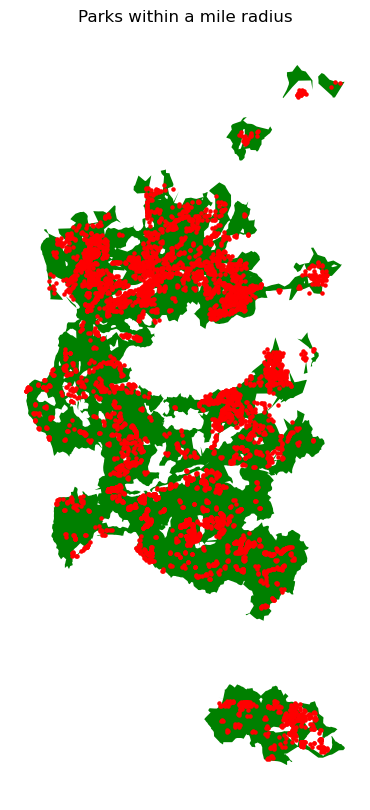

In [41]:
f, ax = plt.subplots(figsize=(12, 10))

s22.plot(color='green', ax=ax)

boundary_gdf.plot(ax=ax, color='red', markersize=5)

plt.title('Parks within a mile radius')

ax.axis('off')

plt.show()

Combined the accessibility information of parks with the previously intersected isochrones for healthcare facilities and schools to further refine the understanding of comprehensive service accessibility in San Diego

Used the gpd.overlay() function again, this time to find the intersection between the dissolved park isochrones (s22) and the already determined intersection areas (intersection_result1) from healthcare facilities and schools.
This operation uses the 'intersection' method to identify and create new geometries that represent the areas where the isochrones of parks, healthcare facilities, and schools overlap.

Purpose of This Intersection:
The resulting intersection (intersection_result2) indicates regions within San Diego where residents have access within a 15-minute travel time to parks, healthcare facilities, and schools. 

### Transit Stops

In [42]:
file_path = 'data/sd_transit/transit_stops_datasd/transit_stops_datasd.shp'
transit = gpd.read_file(file_path)

In [43]:
transit.crs

<Projected CRS: EPSG:2230>
Name: NAD83 / California zone 6 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Imperial; Orange; Riverside; San Diego.
- bounds: (-118.15, 32.53, -114.42, 34.08)
Coordinate Operation:
- name: SPCS83 California zone 6 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [44]:
transit_stops = gpd.sjoin(transit, san_diego_boundary, how='inner', op='within')

Performed a spatial join using gpd.sjoin() to filter and retain only those transit stops that are located within the boundaries of San Diego. This was achieved by setting the join operation to 'inner' and specifying the operation type as 'within', ensuring that only the transit stops that fall within the San Diego boundary are included in the resulting transit_stops GeoDataFrame.

Purpose of the Operation:
This filtering step is crucial for ensuring that subsequent analyses on transit accessibility only consider relevant stops, those actually accessible to residents within the San Diego area.

In [45]:
#transit_stops

In [46]:
transit_stops = transit_stops.to_crs(epsg=4269)


In [47]:
#transit_stops.explore()

### Creating Isochrones for Transit Stops

```isochrones4 = isochrones_from_gdf(transit_stops, threshold=1600, network=sd_network)```

```s23= isochrones4.dissolve()```

```s23.to_file("data/sd_transit_iso/s23.shp")```

Used the refined dataset of transit stops (transit_stops) that are within the boundaries of San Diego, I generated isochrones with a threshold of 1600 meters. This involved using the isochrones_from_gdf function and specifying the San Diego transportation network (sd_network) for calculations.

These isochrones represent the areas accessible within a 15-minute walk from any transit stop, providing a visual representation of transit accessibility across the city.

Purpose of the Isochrones:
The isochrones around transit stops help in understanding how well different parts of San Diego are served by public transportation. 

In [48]:
file_path='data/sd_transit_iso/s23.shp'

In [49]:
s23=gpd.read_file(file_path)

In [50]:
#s23.explore()

In [51]:
s23 = s23.rename(columns={'distance': 'distance_s23'})

intersection_result3 = gpd.overlay(s23, intersection_result2, how='intersection')


In [52]:
#intersection_result3.explore()

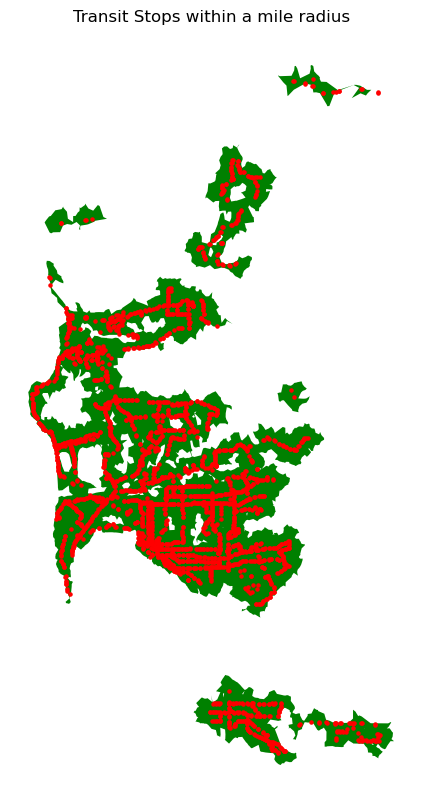

In [53]:
f, ax = plt.subplots(figsize=(12, 10))

s23.plot(color='green', ax=ax)

transit_stops.plot(ax=ax, color='red', markersize=5)

plt.title('Transit Stops within a mile radius')

ax.axis('off')

plt.show()

Performed an intersection operation using gpd.overlay() between the park isochrones (s23) and the previously calculated intersection result (intersection_result2), which already included overlapping areas of healthcare facilities, schools, and parks. This function, set to the 'intersection' method, finds the common areas between these sets of isochrones, thus refining the accessible areas to include proximity to transit stops. 

Purpose of This Intersection: The resulting intersection (intersection_result3) now illustrates the areas within San Diego where residents have within a 15-minute walk access to parks, healthcare facilities, schools, and transit stops.

### GroceryStores

In [54]:
file= 'data/sd_grocery/business_sites.csv'

In [55]:
grocery = pd.read_csv(file)


In [56]:
grocery

,id,apn,bcccode,ownnam1,ownnam2,ownnam3,careof,strnum,strfra,strdir,...,locfra,locdir,locnam,loctyp,locsrm,loccit,bustype,point_x,point_y,geometry
0,0,7602110600,298,AT&T SERVICES INC,NaN,NaN,C/O PROPERTY TAX DEPT,909.0,NaN,NaN,...,NaN,NaN,11TH,ST,NaN,CAMP PENDLETON,MISC PROFESSIONAL,6.210715e+06,2.026933e+06,POINT (-117.3976180797372 33.22364915993219)
1,1,7600801704,2,OCEANSIDE SMALL CRAFT HARBOR,DISTRICT,MARINA INN OCEANSIDE SUITES,NaN,2008.0,NaN,N,...,NaN,N,HARBOR,DR,B,OCEANSIDE,PUBLIC AGENCY,6.210725e+06,2.021698e+06,POINT (-117.3973956129373 33.20926182446687)
2,2,7600801100,41,OCEANSIDE YACHT CLUB INC,NaN,NaN,NaN,1950.0,NaN,N,...,NaN,N,HARBOR,DR,NaN,OCEANSIDE,CLUBS - SOCIAL/SERVI,6.210790e+06,2.022669e+06,POINT (-117.3972182738044 33.21193062172352)
3,3,7600802400,313,ALOHA RESTAURANTS INC,DBA JOLLY ROGER RESTAURANT,#119,ATTN STEVE MOYER,204.0,NaN,NaN,...,NaN,N,HARBOR,DR,NaN,OCEANSIDE,CAFE,6.210974e+06,2.022894e+06,POINT (-117.3966268465309 33.21255490617069)
4,4,7600801000,492,YEARLEY SHARON&MONTE,DBA YEARLEY SAILBOATS,NaN,NaN,1850.0,NaN,N,...,NaN,N,HARBOR,DR,B,OCEANSIDE,BOAT&SUPPLIERS,6.211157e+06,2.023119e+06,POINT (-117.3960360897178 33.21317851869796)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101808,101808,9500000000,314,MAL HEE LEE,DBA I SUSHI,NaN,NaN,945.0,NaN,NaN,...,NaN,NaN,OTAY LAKES,RD,N,CHULA VISTA,CAFE-FAST FOOD,6.333138e+06,1.813900e+06,POINT (-116.992348892535 32.6412214128264)
101809,101809,9500000000,391,WIEBER WILLIAM,DBA BOSNS LOCKER THE,NaN,NaN,946.0,NaN,NaN,...,NaN,NaN,INDUSTRIAL,BLVD,NaN,CHULA VISTA,MACHINE SHOP,6.303025e+06,1.804280e+06,POINT (-117.089912309319 32.61415546184959)
101810,101810,9500000000,295,RADIATION ONCOLOGY SOUTH BAY,LLC,NaN,NaN,310.0,NaN,NaN,...,NaN,NaN,LANE,AVE,B,CHULA VISTA,DOCTOR/OSTEOPA/CHIRO,6.342555e+06,1.817407e+06,POINT (-116.9618397971301 32.65104106448123)
101811,101811,9500000000,298,PACIFIC RAILWAY ENTERPRISES,INC,NaN,NaN,3560.0,NaN,NaN,...,NaN,NaN,CHESAPEAKE,DR,420,SAN DIEGO,MISC PROFESSIONAL,6.293307e+06,1.883807e+06,POINT (-117.1236346602046 32.83250000828478)


In [57]:
from shapely import wkt

grocery['geometry'] = grocery['geometry'].apply(wkt.loads)

gdf_grocery = gpd.GeoDataFrame(grocery, geometry='geometry')

Imported wkt from the shapely library. WKT, or Well-Known Text, is a text markup language for representing vector geometry objects on a map.

Converting Geometry Data:
The geometry column in the grocery DataFrame likely contained geometric data as WKT strings. To work with these geometries in GeoPandas, they needed to be converted into shapely geometry objects. Applied the wkt.loads function to each geometry entry in the grocery['geometry'] column using apply(). This converted the WKT formatted strings into shapely geometry objects, making them usable for spatial operations.

In [58]:
gdf_grocery.set_crs('EPSG:4326', inplace=True)


,id,apn,bcccode,ownnam1,ownnam2,ownnam3,careof,strnum,strfra,strdir,...,locfra,locdir,locnam,loctyp,locsrm,loccit,bustype,point_x,point_y,geometry
0,0,7602110600,298,AT&T SERVICES INC,NaN,NaN,C/O PROPERTY TAX DEPT,909.0,NaN,NaN,...,NaN,NaN,11TH,ST,NaN,CAMP PENDLETON,MISC PROFESSIONAL,6.210715e+06,2.026933e+06,POINT (-117.39762 33.22365)
1,1,7600801704,2,OCEANSIDE SMALL CRAFT HARBOR,DISTRICT,MARINA INN OCEANSIDE SUITES,NaN,2008.0,NaN,N,...,NaN,N,HARBOR,DR,B,OCEANSIDE,PUBLIC AGENCY,6.210725e+06,2.021698e+06,POINT (-117.39740 33.20926)
2,2,7600801100,41,OCEANSIDE YACHT CLUB INC,NaN,NaN,NaN,1950.0,NaN,N,...,NaN,N,HARBOR,DR,NaN,OCEANSIDE,CLUBS - SOCIAL/SERVI,6.210790e+06,2.022669e+06,POINT (-117.39722 33.21193)
3,3,7600802400,313,ALOHA RESTAURANTS INC,DBA JOLLY ROGER RESTAURANT,#119,ATTN STEVE MOYER,204.0,NaN,NaN,...,NaN,N,HARBOR,DR,NaN,OCEANSIDE,CAFE,6.210974e+06,2.022894e+06,POINT (-117.39663 33.21255)
4,4,7600801000,492,YEARLEY SHARON&MONTE,DBA YEARLEY SAILBOATS,NaN,NaN,1850.0,NaN,N,...,NaN,N,HARBOR,DR,B,OCEANSIDE,BOAT&SUPPLIERS,6.211157e+06,2.023119e+06,POINT (-117.39604 33.21318)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101808,101808,9500000000,314,MAL HEE LEE,DBA I SUSHI,NaN,NaN,945.0,NaN,NaN,...,NaN,NaN,OTAY LAKES,RD,N,CHULA VISTA,CAFE-FAST FOOD,6.333138e+06,1.813900e+06,POINT (-116.99235 32.64122)
101809,101809,9500000000,391,WIEBER WILLIAM,DBA BOSNS LOCKER THE,NaN,NaN,946.0,NaN,NaN,...,NaN,NaN,INDUSTRIAL,BLVD,NaN,CHULA VISTA,MACHINE SHOP,6.303025e+06,1.804280e+06,POINT (-117.08991 32.61416)
101810,101810,9500000000,295,RADIATION ONCOLOGY SOUTH BAY,LLC,NaN,NaN,310.0,NaN,NaN,...,NaN,NaN,LANE,AVE,B,CHULA VISTA,DOCTOR/OSTEOPA/CHIRO,6.342555e+06,1.817407e+06,POINT (-116.96184 32.65104)
101811,101811,9500000000,298,PACIFIC RAILWAY ENTERPRISES,INC,NaN,NaN,3560.0,NaN,NaN,...,NaN,NaN,CHESAPEAKE,DR,420,SAN DIEGO,MISC PROFESSIONAL,6.293307e+06,1.883807e+06,POINT (-117.12363 32.83250)


In [59]:
grocery = gdf_grocery.to_crs('EPSG:2230')

In [60]:
grocery = gpd.sjoin(grocery, san_diego_boundary, how='inner', op='within')

Performed a spatial join between the grocery GeoDataFrame, which now contains properly formatted geometric data, and the san_diego_boundary GeoDataFrame.
By setting how='inner' and op='within', I ensured that only those grocery stores located within the San Diego boundary are included in the resulting GeoDataFrame. This operation discards any grocery store data points that lie outside the boundaries of San Diego.

Purpose of the Operation:
This spatial join is essential for focusing subsequent analyses solely on grocery stores relevant to the San Diego area. 

In [61]:
grocery= grocery.to_crs(epsg=4269)

In [62]:
grocery_stores = grocery[grocery['bustype'] == 'GROCERY STORES']

In [63]:
#grocery_stores.explore()

Used a conditional statement to filter the grocery DataFrame, selecting only rows where the bustype column equals "GROCERY STORES". This operation ensures that the resulting DataFrame, grocery_stores, exclusively contains data pertaining to businesses identified as grocery stores.

### Creating Isochrones for Grocery Stores

```isochrones5 = isochrones_from_gdf(grocery_stores, threshold=1600, network=sd_network)```

```s24= isochrones5.dissolve()```

Generated isochrones with the isochrones_from_gdf function. The threshold was set to 1600 meters, indicating the areas reachable within this distance from each grocery store, using the San Diego transportation network (sd_network).

The function outputs isochrones5, a GeoDataFrame containing the geometric representations of these accessibility areas.

Purpose of Creating Isochrones:
These isochrones help visualize the reach of grocery stores, providing insight into how accessible they are to residents of San Diego.

```s24.to_file("data/sd_grocery_iso/s24.shp")```

In [64]:
file_path='data/sd_grocery_iso/s24.shp'
s24=gpd.read_file(file_path)

In [65]:
s24 = s24.rename(columns={'distance': 'distance_s24'})

intersection_result4 = gpd.overlay(s24, intersection_result3, how='intersection')

In [66]:
#intersection_result4.explore()

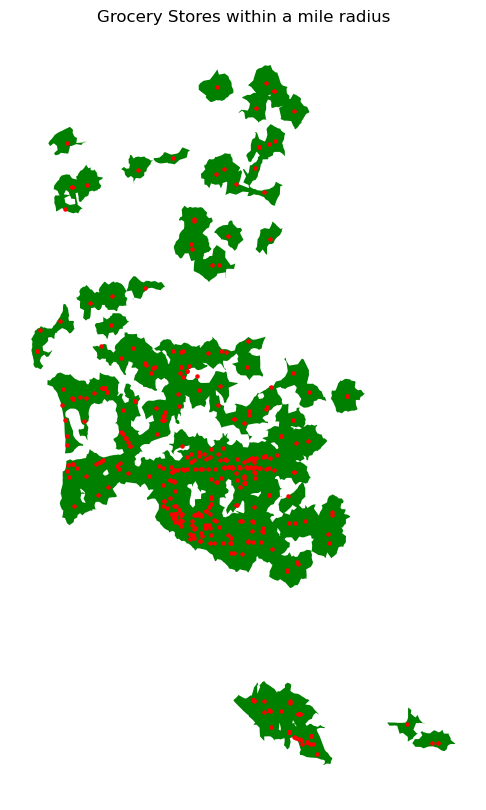

In [67]:
f, ax = plt.subplots(figsize=(12, 10))

s24.plot(color='green', ax=ax)

grocery_stores.plot(ax=ax, color='red', markersize=5)

plt.title('Grocery Stores within a mile radius')

ax.axis('off')

plt.show()

Used the gpd.overlay() function to perform another intersection, this time incorporating the grocery store isochrones (s24) with the previously computed intersection result (intersection_result3). This method was set to 'intersection', which calculates the geometric overlap between these sets.

Purpose of This Intersection:
This operation resulted in intersection_result4, which represents areas within San Diego where residents have access within a 15-minute walk to parks, healthcare facilities, schools, transit stops, and now, grocery stores.

### Religion

In [68]:
# file_path="data/sd_worship/Places.shp"
# religion=gpd.read_file(file_path)

In [69]:
#religion.crs

In [70]:
#san_diego_boundary.crs

In [71]:
# religion = religion.to_crs('EPSG:2230')

In [72]:
# religion = gpd.sjoin(religion, san_diego_boundary, how='inner', op='within')

In [73]:
# unique_types = religion['TYPE'].unique()


In [74]:
#unique_types

In [75]:
# ri_variables = ['ReligiousStructure_C', 'ReligiousStructure_B', 'ReligiousStructure',
#                 'ReligiousStructure_M', 'ReligiousStructure_H', 'ReligiousStructure_J']

In [76]:
# sd_religion = religion[religion['TYPE'].isin(ri_variables)]


In [77]:
sdPow = gpd.read_file('./data/sd_worship/spatial-joins/sdPow.geojson')

First conducted a spatial join between the religion GeoDataFrame and the san_diego_boundary GeoDataFrame. The how='inner' parameter ensured that only religious structures located within the San Diego boundary were included, and op='within' confirmed that the structures are indeed within these geographic limits.

Identifying Unique Types:
To understand the different categories of religious structures within the dataset, I extracted unique types from the 'TYPE' column using the .unique() method. This would help in identifying specific categories of interest for further analysis.

Filtering Specific Categories:
Based on the unique types identified, I created a list, ri_variables, containing selected types of religious structures to focus on, such as 'ReligiousStructure_C', 'ReligiousStructure_B', etc.
I then filtered the religion GeoDataFrame to include only the entries whose 'TYPE' matched one of the types in ri_variables. This filtering was done using the .isin() method, which checks each 'TYPE' entry against the list of specified categories.

In [78]:
file_path="data/sd_worship/Isochrones/riid.shp"
sd_relig=gpd.read_file(file_path)

In [79]:
sd_relig = sd_relig.rename(columns={'distance': 'distance_religion'})

intersection_result5 = gpd.overlay(sd_relig, intersection_result4, how='intersection')

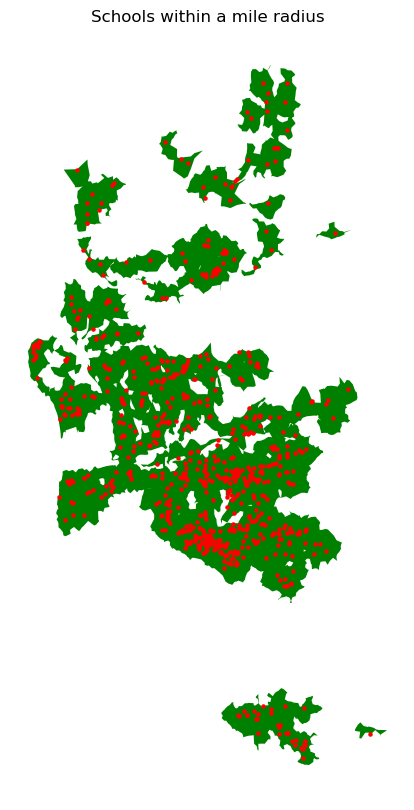

In [80]:
f, ax = plt.subplots(figsize=(12, 10))

sd_relig.plot(color='green', ax=ax)

sdPow.plot(ax=ax, color='red', markersize=5)

plt.title('Schools within a mile radius')

ax.axis('off')

plt.show()

Utilized the gpd.overlay() function to intersect the filtered religious structures dataset (sd_relig), which includes specific types of religious facilities, with the previously obtained intersection result (intersection_result4). This result already encompassed areas with access to parks, healthcare facilities, schools, transit stops, and grocery stores.

The method specified for this operation was 'intersection', which computes the geometric overlap between these two data sets.

Purpose of This Intersection:
The new intersection (intersection_result5) now encapsulates regions within San Diego where access to religious structures is also within a 15-minute walk, alongside other essential services.

## Spatial Analysis
---

### Import of American Community Survey Data using GeoSnap

In [81]:
intersection_result5['access']='access'

Assigned a label 'access' to the intersection_result5 GeoDataFrame. This label presumably marks the areas identified as having good accessibility to multiple essential services, 

In [82]:
#intersection_result5.explore()

In [83]:
acs21 = datasets.acs('2021')

<Axes: >

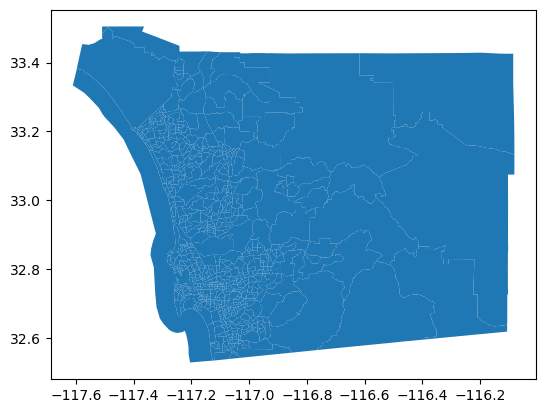

In [84]:
san_diego_county_tracts = acs21[acs21['geoid'].str.startswith('06073')]
san_diego_county_tracts.plot()

In [85]:
san_diego_county_tracts = san_diego_county_tracts.to_crs('EPSG:2230')

In [86]:
#san_diego_county_tracts.explore()

In [87]:
#san_diego_boundary.explore()

In [88]:
tracts_within_boundary1 = gpd.overlay(san_diego_county_tracts, san_diego_boundary, how='intersection')
#tracts_within_boundary1.explore()

<Axes: >

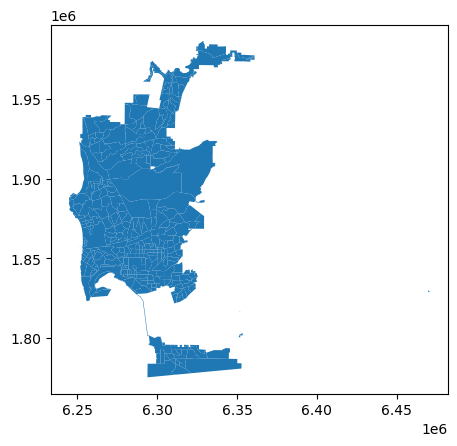

In [89]:
tracts_within_boundary1.plot()

Used gpd.overlay() to intersect the san_diego_county_tracts GeoDataFrame, which contains demographic data for census tracts within San Diego County, with the san_diego_boundary GeoDataFrame. The operation was set to 'intersection', ensuring that the output, tracts_within_boundary1, includes only those parts of census tracts that lie within the official boundaries of the city of San Diego.

In [90]:
tracts_within_boundary = tracts_within_boundary1[['geometry']]

In [91]:
tracts_within_boundary

,geometry
0,"POLYGON ((6271212.508 1855074.386, 6271393.972..."
1,"POLYGON ((6276375.410 1856718.155, 6276654.562..."
2,"POLYGON ((6274535.866 1852524.707, 6274558.408..."
3,"POLYGON ((6279287.227 1853533.698, 6279509.232..."
4,"POLYGON ((6280617.190 1850738.841, 6280617.938..."
...,...
387,"POLYGON ((6352772.450 1801762.759, 6352767.567..."
388,"POLYGON ((6351761.045 1816825.711, 6351840.851..."
389,"POLYGON ((6351891.449 1816666.945, 6351840.851..."
390,"POLYGON ((6328113.555 1894641.743, 6328114.513..."


In [92]:
tracts_within_boundary['unique']="yes"

Added a column that could easily identify the tracts for the City of San Diego

In [93]:
#tracts_within_boundary.explore()

In [94]:
union = gpd.overlay(san_diego_county_tracts[["geometry"]],tracts_within_boundary , how='union')
#union.explore()

Created a union of the San Diego city tracts (already intersected with the city boundary) and the entire set of San Diego county tracts. The union operation in this context helps to create a comprehensive layer that includes both city-specific and county-wide census tracts.

In [95]:
import tobler

interpolated_data = tobler.area_weighted.area_interpolate(
    san_diego_county_tracts,
     union,
    extensive_variables=['n_total_pop'],
   intensive_variables=['per_capita_income','p_nonhisp_black_persons', 'p_hispanic_persons', 
                        'p_nonhisp_white_persons','p_asian_persons']
)

Used Tobler’s area-weighted interpolation method (tobler.area_weighted.area_interpolate()) to interpolate demographic data from the county tracts to the newly created union of city and county tracts. This method is particularly useful for estimating demographic statistics in regions where the geographic boundaries do not align perfectly with census data.

Variables: The interpolation included both extensive variables (e.g., 'n_total_pop') which are total counts that need to be proportionally allocated based on area, and intensive variables (e.g., 'per_capita_income', 'p_nonhisp_black_persons') which are ratios or percentages and need to be averaged based on the new geographic definitions.

Purpose: The primary goal here is to provide accurate and detailed demographic profiles for the entire city of San Diego by adjusting the county-level ACS data to fit the actual city boundaries. 

In [96]:
#interpolated_data.explore()

In [97]:
interpolated_data.crs

<Projected CRS: EPSG:2230>
Name: NAD83 / California zone 6 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Imperial; Orange; Riverside; San Diego.
- bounds: (-118.15, 32.53, -114.42, 34.08)
Coordinate Operation:
- name: SPCS83 California zone 6 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [98]:
interpolated_data['unique'] = union.unique


Added the column unique from the union

In [99]:
subset_data = interpolated_data[interpolated_data['unique'] == 
'yes']


created a geodaframe called subset_data which represents the tracts for the City of San Diego

In [100]:
subset_data.crs

<Projected CRS: EPSG:2230>
Name: NAD83 / California zone 6 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Imperial; Orange; Riverside; San Diego.
- bounds: (-118.15, 32.53, -114.42, 34.08)
Coordinate Operation:
- name: SPCS83 California zone 6 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [101]:
subset_data= subset_data.to_crs(epsg=4269)


In [102]:
union1 = gpd.overlay(subset_data[["geometry"]],intersection_result5 , how='union')
#union1.explore()

Performed a union of this subset data with the intersection_result5 GeoDataFrame. The intersection_result5 contains areas identified as accessible based on previous multi-criteria accessibility analyses (including amenities like parks, schools, healthcare facilities, etc.).

The union operation, performed via gpd.overlay() with the method set to "union", combines the geographic areas of subset_data (City of San Diego) and intersection_result5(intersection of all isochrones)

In [103]:
union1.fillna('no_access', inplace=True)



Areas outside the isochrones were filled with no_access

In [104]:
#import geopandas as gpd
#union1.explore(column='access', cmap='coolwarm', legend=True)

In [105]:
interpolated_data = tobler.area_weighted.area_interpolate(
    subset_data,
     union1,
    extensive_variables=['n_total_pop'],
   intensive_variables=['per_capita_income','p_nonhisp_black_persons', 'p_hispanic_persons', 
                        'p_nonhisp_white_persons','p_asian_persons']
)

used tobler again beacause the union between the isochrones and the city of san diego results in new geometry.

In [106]:
#interpolated_data.explore()

In [107]:
interpolated_data['access'] = union1.access

In [108]:
#interpolated_data.explore()

In [109]:
#interpolated_data.to_file('data/sd_interpolation')

In [110]:
import pandas as pd
pd.options.display.float_format='{:.0f}'.format

In [111]:
interpolated_data[['n_total_pop', 'access']].groupby(by='access').sum()


,n_total_pop
access,
access,453992
no_access,920725


### Number of Services

In [112]:
s20['school_service']=1

In [113]:
health_iso['health_service']=1

In [114]:
service_union = gpd.overlay(health_iso, s20, how='union')
service_union.dissolve()

,geometry,distance_1,distance_2,health_service,distance,school_service
0,"MULTIPOLYGON (((-117.24736 32.71572, -117.2474...",1600,1600,1,1600,1


In [115]:
san_diego_boundary = san_diego_boundary[['geometry']]
san_diego_boundary

,geometry
0,"POLYGON ((6311198.000 1935485.999, 6311197.956..."
1,"POLYGON ((6328112.751 1894696.276, 6328113.555..."
2,"POLYGON ((6470708.439 1829214.124, 6470142.888..."
3,"POLYGON ((6351603.135 1816566.962, 6351578.989..."
4,"POLYGON ((6351790.767 1800504.719, 6351742.153..."


In [116]:
san_diego_boundary = san_diego_boundary.to_crs('EPSG:4326')

In [117]:
service_union = gpd.overlay(service_union, san_diego_boundary, how='union')

In [118]:
s22['park_service']=1

In [119]:
service_union = gpd.overlay(service_union, s22, how='union')
service_union.dissolve()

,geometry,distance_1,distance_2,health_service,distance,school_service,distance_parks,park_service
0,"MULTIPOLYGON (((-117.25727 32.72313, -117.2572...",1600,1600,1,1600,1,1600,1


In [120]:
s23['transit_service']=1

In [121]:
service_union = gpd.overlay(service_union, s23, how='union')
service_union.dissolve()

,geometry,distance_1,distance_2,health_service,distance,school_service,distance_parks,park_service,distance_s23,transit_service
0,"MULTIPOLYGON (((-117.25727 32.72313, -117.2572...",1600,1600,1,1600,1,1600,1,1600,1


In [122]:
s24['grocery_service']=1

In [123]:
service_union = gpd.overlay(service_union, s24, how='union')
service_union.dissolve()

,geometry,distance_1,distance_2,health_service,distance,school_service,distance_parks,park_service,distance_s23,transit_service,distance_s24,grocery_service
0,"MULTIPOLYGON (((-117.25727 32.72313, -117.2572...",1600,1600,1,1600,1,1600,1,1600,1,1600,1


In [124]:
sd_relig['religion_service']=1

In [125]:
service_union = gpd.overlay(service_union, sd_relig, how='union')
service_union.dissolve()

,geometry,distance_1,distance_2,health_service,distance,school_service,distance_parks,park_service,distance_s23,transit_service,distance_s24,grocery_service,distance_religion,religion_service
0,"MULTIPOLYGON (((-117.25727 32.72313, -117.2572...",1600,1600,1,1600,1,1600,1,1600,1,1600,1,1600,1


In [126]:
service_union.fillna(0, inplace=True)


In [127]:
service_union['combined_services']=service_union['transit_service'] + service_union['park_service']+service_union['health_service']+service_union['school_service']+service_union['grocery_service']+service_union['religion_service']

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, figsize=(7, 7))
service_union.plot(
    column="combined_services", categorical=True, legend=True, linewidth=0, ax=ax
)
plt.title('The distribution of total services within San Diego')
ax.set_axis_off()
plt.show()

Individually marked services (school, health, parks, transit, grocery, and religion) across various GeoDataFrames like s20, health_iso, s22, s23, s24, and sd_relig with a value of 1. This marking indicates the presence of a specific service in that geographic area.

Creating Union of Services:
Using gpd.overlay() with the 'union' method, systematically combined these marked services into a single GeoDataFrame called service_union. This approach allows to consolidate the geographic coverage of each service into a unified spatial dataset.

Dissolving Boundaries:
Applied the .dissolve() method to the service_union to merge all overlapping and adjacent polygons. This step simplifies the map and creates a continuous area that accurately represents the coverage of all services combined without internal boundaries.

Calculating Total Services:
Summing the individual service markers within service_union, created a new column combined_services which provides a total count of different services available within each area of the service_union. This quantifies the level of service availability in a given area, providing a straightforward metric for assessing service richness.